In [116]:
from ibkethlib.node import Ethnode as node
from ibkethlib.db import Ethstore as store
from ibkethlib.db import Block
from ibkethlib.environment import Ethenvironment as env

from datetime import datetime
import json
import math
import itertools
import textwrap
import functools
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import matplotlib2tikz
import csv


# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Display figures inline in Jupyter notebook
from IPython.display import (
    display_pretty, display_html, display_jpeg,
    display_png, display_json, display_latex, display_svg
)

tqdm.pandas()


dataPath = env.getDataPath() / "airdrops" / "simulation"

sim_file = dataPath / "simulation.csv"

#BLOCKGASLIMIT=6712392

def plot(data, hline, title, column="value"):
    fig, ax = pyplot.subplots(figsize=(15, 10))
    
    fig.suptitle(title)
    plt.xlabel('Recipients')
    plt.ylabel('Gas Used')
    

    sns.lineplot(ax = ax, x="#", y = column, hue='name', data=data)
    ##axes = sim.lineplot(marker='.', alpha=0.5, linestyle='dashed', figsize=(11, 9), subplots=False)
    l = hline
    m = data[column].max()
    i = 1
    while (i*l) < m:
        ax.axhline(linewidth=1, y=i*hline, color='r', linestyle="--", label=str(i))
        i+=1
        
    fig.savefig(dataPath / '{}.jpg'.format(title))
    matplotlib2tikz.save(dataPath / '{}.tex'.format(title))
        
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
def parseNames(x):
    def translate(y):
        if RepresentsInt(y):
            return str(y)
        elif y=="EB":
            return "EXTERNAL_BATCH"
        elif y=="IB":
            return "INTERNAL_BATCH"
        elif y=="OA":
            return "UNIFORM"
        elif y=="P":
            return "PUSH"
        elif y=="PL":
            return "PULL"
        elif y=="U":
            return "RECIPIENT_COST"
        elif y=="N":
            return "NAIVE"
        elif y=="O":
            return "BASE_LINE"
        else:
            raise Exception("unknown token" + y) 
    return "|".join(list(map(translate ,x.split("_"))))

# N_P
# EB_P_OA_100
# EB_P_OA_200
# EB_P_OA_300
# EB_P_OA_400
# EB_P100
# EB_P200
# EB_P300
# EB_P400
# IB_P_OA100
# IB_P_OA200
# IB_P_OA300
# IB_P_OA400
# IB_P100
# IB_P200
# IB_P300
# IB_P400
# IB_PL_OA100
# IB_PL_OA200
# IB_PL_OA300
# IB_PL_OA400
# IB_PL100
# IB_PL200
# IB_PL300
# IB_PL400
# IB_PL_OA_U100
# IB_PL_OA_U200
# IB_PL_OA_U300
# IB_PL_OA_U400
# IB_PL_U100
# IB_PL_U200
# IB_PL_U300
# IB_PL_U400
def loadFile():
    sim = pd.read_csv(sim_file, sep=";")
    def inputCost(set_b):
        return 68 * set_b + 4 * (32 - set_b)
    def baseline(n, batch, one_amount, val_bytes_set=2):
        tx_count = math.ceil(n/batch)
        tx_base_cost = (tx_count * 21000)
        sstore_base_cost = (n * 20000)
        # per recipient 20 byte address nn = 12 byte padding, 
        # Gtxdatazero 4 Paid for every zero byte of data or code for a transaction.
        # Gtxdatanonzero 68 Paid for every non-zero byte of data or code for a transaction.
        # Gtransaction 21000 Paid for every transaction.
        # In our case 
        tx_base_one_addess = inputCost(20)
        tx_base_one_value = inputCost(val_bytes_set)
        tx_base_one = tx_base_one_addess + (tx_base_one_value if not one_amount else 0)
        tx_input_basecost = n * tx_base_one + (tx_base_one_value if one_amount else 0)
        
        return tx_base_cost + sstore_base_cost + tx_input_basecost
        
    sim["O_IB_P_OA_100"] = sim.apply(lambda row: baseline(row["#"], 100, True), axis=1)
    sim["O_IB_P_OA_200"] = sim.apply(lambda row: baseline(row["#"], 200, True), axis=1)
    sim["O_IB_P_OA_300"] = sim.apply(lambda row: baseline(row["#"], 300, True), axis=1)
    sim["O_IB_P_OA_400"] = sim.apply(lambda row: baseline(row["#"], 400, True), axis=1)
    sim["O_IB_P_OA_500"] = sim.apply(lambda row: baseline(row["#"], 500, True), axis=1)
    sim["O_IB_P_OA_600"] = sim.apply(lambda row: baseline(row["#"], 600, True), axis=1)
    sim["O_IB_P_OA_700"] = sim.apply(lambda row: baseline(row["#"], 700, True), axis=1)
    sim["O_IB_P_OA_800"] = sim.apply(lambda row: baseline(row["#"], 800, True), axis=1)
    
    #TODO: add lower bound simulation
    res = sim.rename(columns={'EB_P100':'EB_P_100',
                               'EB_P200':'EB_P_200',
                               'EB_P300':'EB_P_300',
                               'EB_P400':'EB_P_400',
                               'IB_P_OA100':'IB_P_OA_100',
                               'IB_P_OA200':'IB_P_OA_200',
                               'IB_P_OA300':'IB_P_OA_300',
                               'IB_P_OA400':'IB_P_OA_400',
                               'IB_P100':'IB_P_100',
                               'IB_P200':'IB_P_200',
                               'IB_P300':'IB_P_300',
                               'IB_P400':'IB_P_400',
                               'IB_PL_OA100':'IB_PL_OA_100',
                               'IB_PL_OA200':'IB_PL_OA_200',
                               'IB_PL_OA300':'IB_PL_OA_300',
                               'IB_PL_OA400':'IB_PL_OA_400',
                               'IB_PL100':'IB_PL_100',
                               'IB_PL200':'IB_PL_200',
                               'IB_PL300':'IB_PL_300',
                               'IB_PL400':'IB_PL_400',
                               'IB_PL_OA_U100':'IB_PL_OA_U_100',
                               'IB_PL_OA_U200':'IB_PL_OA_U_200',
                               'IB_PL_OA_U300':'IB_PL_OA_U_300',
                               'IB_PL_OA_U400':'IB_PL_OA_U_400',
                               'IB_PL_U100':'IB_PL_U_100',
                               'IB_PL_U200':'IB_PL_U_200',
                               'IB_PL_U300':'IB_PL_U_300',
                               'IB_PL_U400':'IB_PL_U_400'                               
                              }, 
                 inplace=False)
    res.to_csv(dataPath / "simulation_baseline.csv")
    return res
        
    
def parseBatch(x):
    return next((y for y in x.split("_") if RepresentsInt(y)), 1)
    
def transformMelted(data, value_field="value"):
    data["name"] = data["variable"].apply(lambda x: parseNames(x))
    data["batch_size"] = data["variable"].apply(lambda x: parseBatch(x)).astype('int64')
    # Every participant calculated with store to new address. if lower bound then 
    data["discounted_value"] = data["value"] - (data["#"] * 15000)
    #data["cost_eth_low"] = (data[value_field] * CHEAPEST_GAS_PRICE_WEI) / 10**18
    data["cost_eth_low"] = data[value_field].apply(lambda v: round((v * CHEAPEST_GAS_PRICE_WEI) / 10**18, 6))
    data["cost_eth_median"] = data[value_field].apply(lambda v: round((v * MEDIAN_GAS_PRICE_WEI) / 10**18, 6))
    data["cost_eth_high"] = data[value_field].apply(lambda v: round((v * HIGHEST_GAS_PRICE_WEI) / 10**18, 6)) # (data[value_field] * HIGHEST_GAS_PRICE_WEI) / 10**18
    #data["cost_eth_median"] = (data[value_field] * MEDIAN_GAS_PRICE_WEI) / 10**18
    data["#tx"] = data["#"] / data["batch_size"]
    data["#tx_needed_10"] = data[value_field] / BLOCKGASLIMIT_10
    data["#tx_needed_25"] = data[value_field] / BLOCKGASLIMIT_25
    data["#tx_needed_50"] = data[value_field] / BLOCKGASLIMIT_75
    data["#tx_needed_75"] = data[value_field] / BLOCKGASLIMIT
    data["#tx_needed"] = data[value_field] / BLOCKGASLIMIT
    data["gas_per_tx"] = data[value_field] / data["#tx"]
    data["block_fill_10"] = data["gas_per_tx"] / BLOCKGASLIMIT_10
    data["block_fill_25"] = data["gas_per_tx"] / BLOCKGASLIMIT_25
    data["block_fill_50"] = data["gas_per_tx"] / BLOCKGASLIMIT_50
    data["block_fill_75"] = data["gas_per_tx"] / BLOCKGASLIMIT_75
    data["block_fill"] = data["gas_per_tx"] / BLOCKGASLIMIT

    return data


In [25]:
#https://ethgasstation.info/

# 0.58  gwei
# 1 Ether = 1,000,000,000 Gwei 
# 1 Ether =  1,000,000,000,000,000,000 Wei (1018)
CHEAPEST_GAS_PRICE_WEI = int(0.58 * 10**9)
MEDIAN_GAS_PRICE_WEI = int(10.5 * 10**9)
HIGHEST_GAS_PRICE_WEI = 235 * 10**9

display(HIGHEST_GAS_PRICE_WEI)
display(MEDIAN_GAS_PRICE_WEI)
display(CHEAPEST_GAS_PRICE_WEI)

235000000000

10500000000

580000000

In [67]:
# Blocks and date

#"2017-12-31T23:59:59.000+0000"
fromd = datetime(2017, 12, 31, 23, 59, 59)
#"2018-12-31T23:59:59.000+0000" 
tod = datetime(2018, 12, 31, 23, 59, 59)

with store() as s:
    blocks = Block.objects(__raw__={ "$and": [ { "date": { "$gt":  fromd} }, { "date": { "$lt": tod} } ] }).as_pymongo()

df_blocks = pd.DataFrame(list(blocks))
df_blocks.rename(columns={'nr':'block'}, 
                 inplace=True)
df_blocks = df_blocks.drop(columns=['_id'])
#display(df_blocks)
BLOCKGASLIMIT = math.ceil(df_blocks["gasLimit"].mean())
BLOCKGASLIMIT_75 = math.ceil(BLOCKGASLIMIT *0.75)
BLOCKGASLIMIT_50 = math.ceil(BLOCKGASLIMIT *0.50)
BLOCKGASLIMIT_25 = math.ceil(BLOCKGASLIMIT *0.25)
BLOCKGASLIMIT_10 = math.ceil(BLOCKGASLIMIT *0.10)

#display(df_blocks)

BLOCKGASLIMIT

BLOCKGASLIMIT_50

,date,gasLimit,block
0,2018-01-01 00:00:02,7992185,4832686
1,2018-01-01 00:00:12,7999955,4832687
2,2018-01-01 00:00:14,8000029,4832688
3,2018-01-01 00:00:19,8000000,4832689
4,2018-01-01 00:00:25,8003872,4832690
5,2018-01-01 00:00:34,7996070,4832691
6,2018-01-01 00:00:51,8000029,4832692
7,2018-01-01 00:00:57,7992222,4832693
8,2018-01-01 00:01:22,7999992,4832694
9,2018-01-01 00:01:38,8003875,4832695


3998836

# Plot

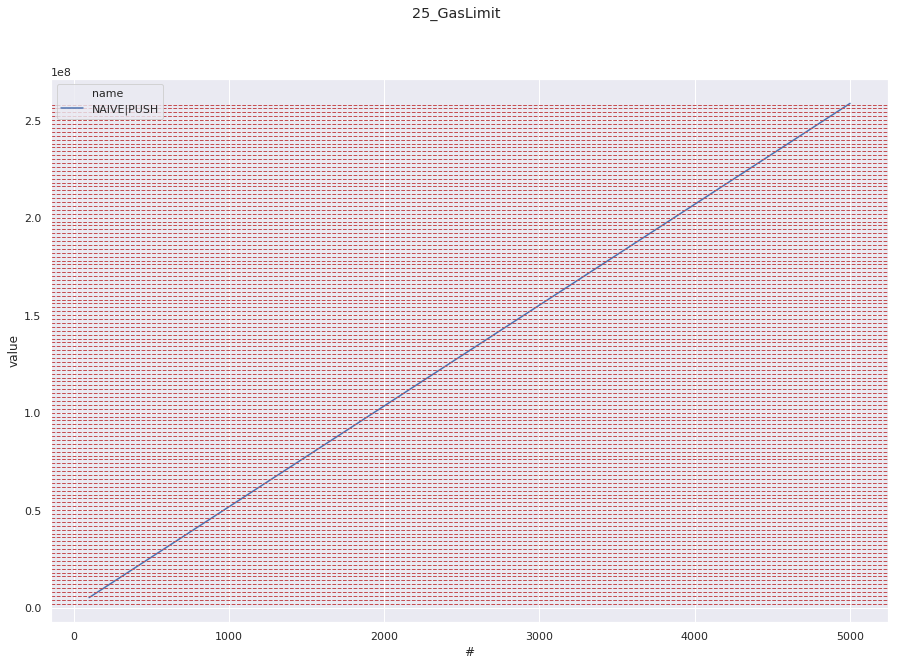

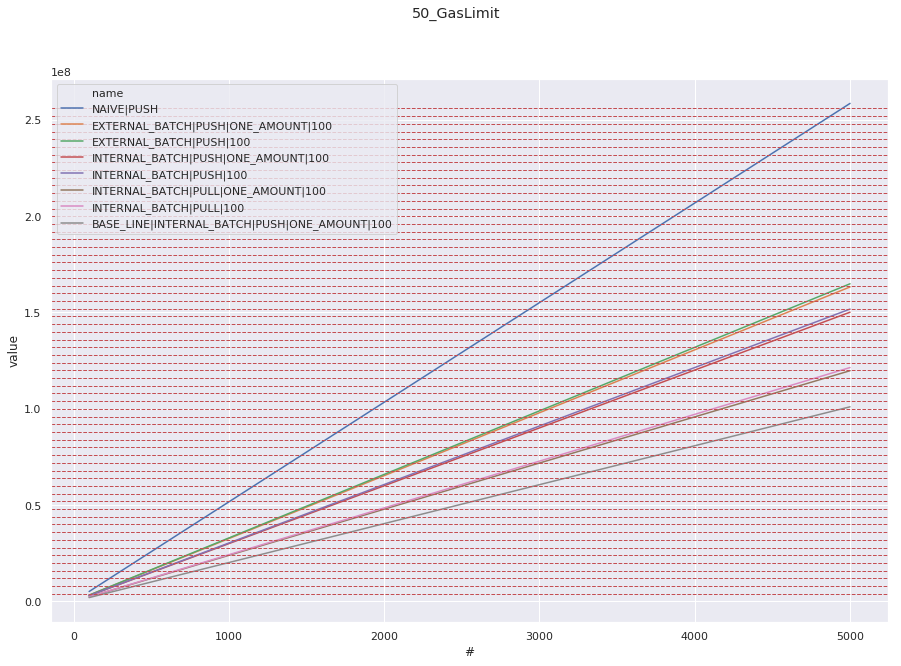

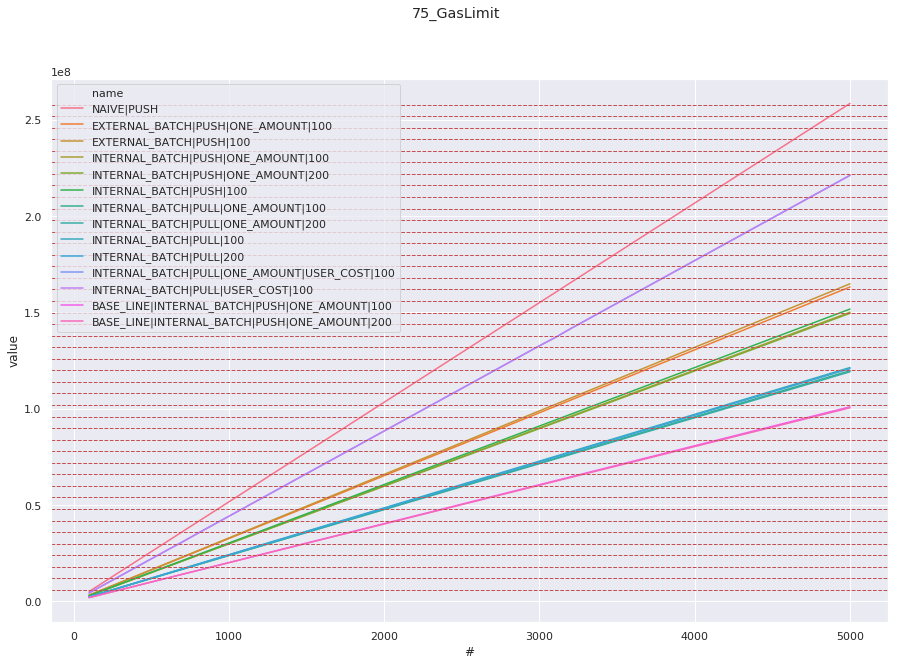

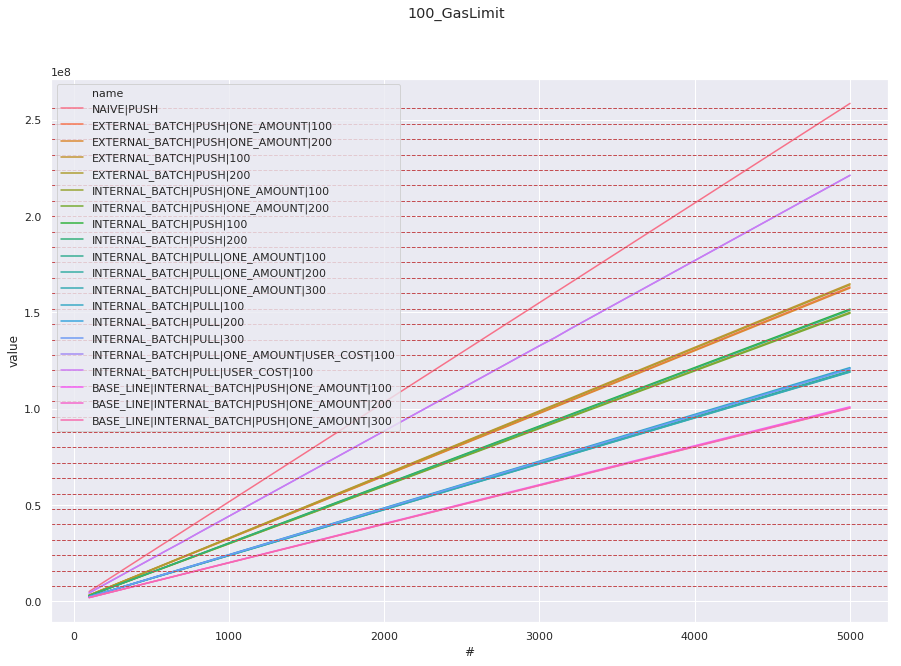

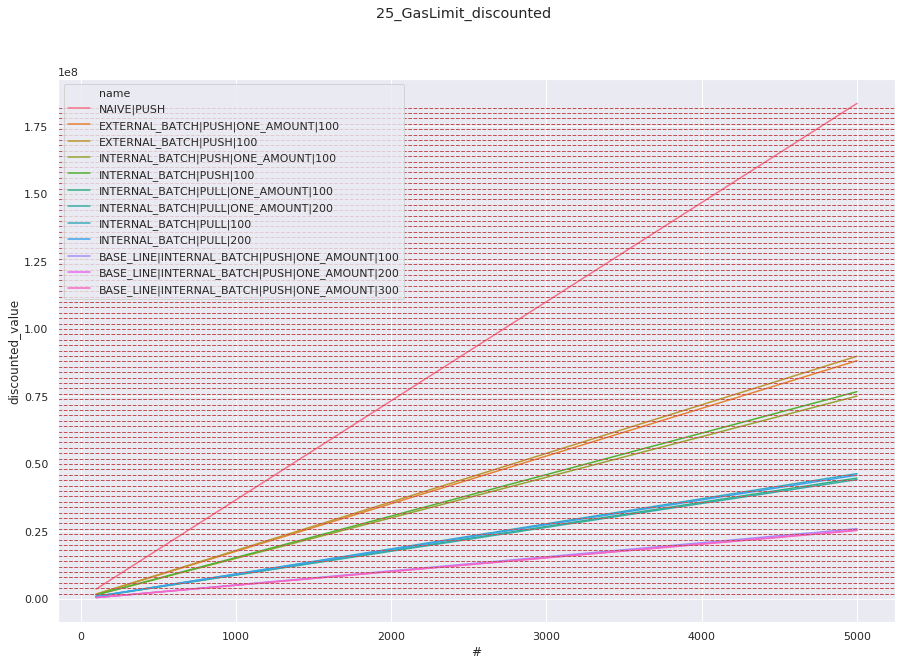

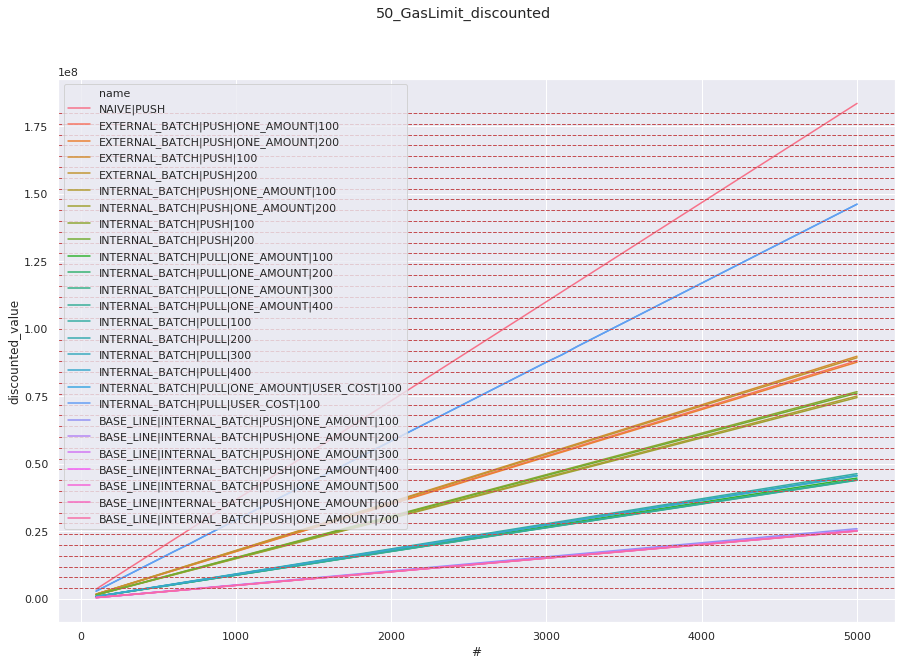

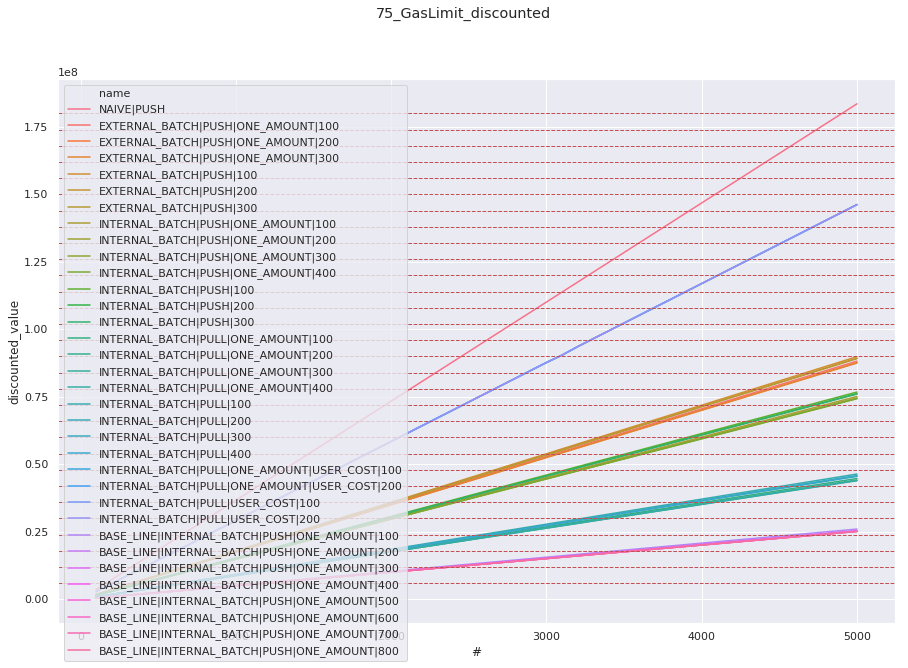

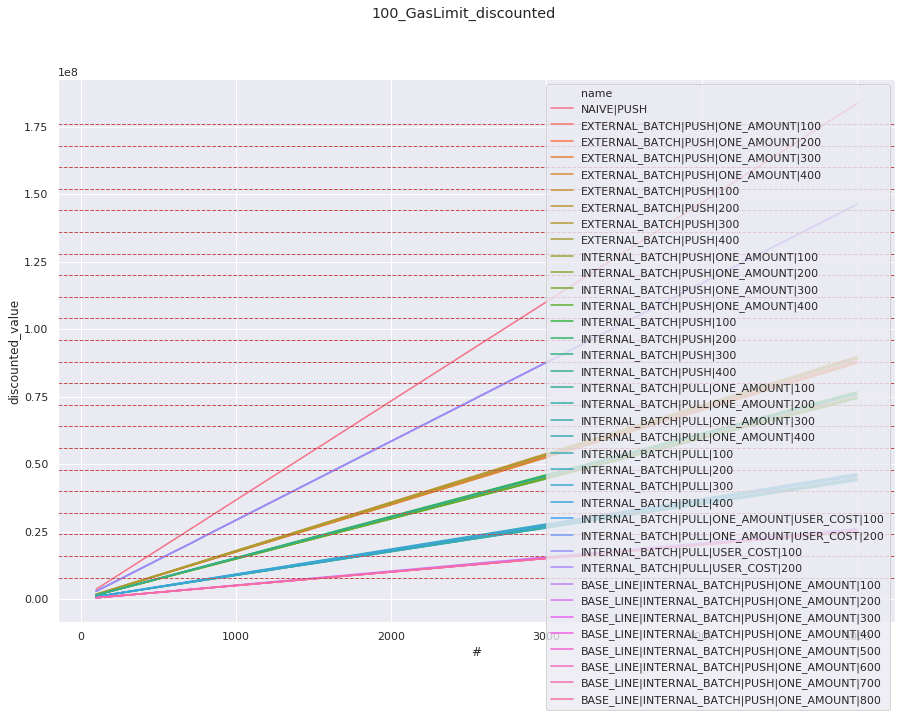

In [14]:
def generate_plots(sim2, extension="", column="value"):
    sim_10 = sim2[sim2["block_fill_10"] <= 1]
    sim_25 = sim2[sim2["block_fill_25"] <= 1]
    sim_50 = sim2[sim2["block_fill_50"] <= 1]
    sim_75 = sim2[sim2["block_fill_75"] <= 1]
    sim_100 = sim2[sim2["block_fill"] <= 1]

    #plot(sim_75, BLOCKGASLIMIT_75)
    plot(sim_25, BLOCKGASLIMIT_25, "25_GasLimit{}".format(extension), column)
    plot(sim_50, BLOCKGASLIMIT_50, "50_GasLimit{}".format(extension), column)
    plot(sim_75, BLOCKGASLIMIT_75, "75_GasLimit{}".format(extension), column)
    plot(sim_100, BLOCKGASLIMIT, "100_GasLimit{}".format(extension), column)
    

sim = loadFile()
#display(sim)
#display(sim)
sim2 = transformMelted(pd.melt(sim, ['#']), "value") # "discounted_value"

sim2.to_csv(dataPath / "annotated_simulation.csv")

sim2_discounted = transformMelted(pd.melt(sim, ['#']), "discounted_value")

sim2_discounted.to_csv(dataPath / "annotated_simulation_discounted.csv")

generate_plots(sim2)#, column="cost_eth_median")
generate_plots(sim2_discounted, "_discounted", "discounted_value")


#display(sim2)


# Export to Tikz

line plot for 50 % Blockfill

In [118]:
sim = loadFile()
#display(sim)
#display(sim)
sim2 = transformMelted(pd.melt(sim, ['#']), "value") # "discounted_value"

sim_50 = sim2[sim2["block_fill_50"] <= 1]

# User cost is not batched so include also since not batched we can just pick one since all the same
cols = list(sim_50.name.unique()) + [parseNames("IB_PL_U_100"), parseNames("IB_PL_OA_U_100")] 
print(cols)
for x in cols:
    val_col = "value" # value
    one_line = sim2[sim2["name"]==x]
    forplot = one_line[["#",val_col]]
    forplot[val_col] = forplot[val_col] / 10**5

    forplot.to_csv(dataPath / "line_50_{}_{}.csv".format(val_col, x), sep="\t", index=False)

['NAIVE|PUSH', 'EXTERNAL_BATCH|PUSH|UNIFORM|100', 'EXTERNAL_BATCH|PUSH|100', 'INTERNAL_BATCH|PUSH|UNIFORM|100', 'INTERNAL_BATCH|PUSH|100', 'INTERNAL_BATCH|PULL|UNIFORM|100', 'INTERNAL_BATCH|PULL|100', 'BASE_LINE|INTERNAL_BATCH|PUSH|UNIFORM|100', 'INTERNAL_BATCH|PULL|RECIPIENT_COST|100', 'INTERNAL_BATCH|PULL|UNIFORM|RECIPIENT_COST|100']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
bar plot data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

9       \draw [green!50!black] (1,0)--++(0,517.0488) n...
59      \draw [blue!50!black] (2,0)--++(0,326.5184) no...
109     \draw [red!50!black] (3,0)--++(0,325.3917) nod...
159     \draw [black] (4,0)--++(0,325.16945) node[abov...
209     \draw [black] (5,0)--++(0,324.94464) node[abov...
259     \draw [blue!50!black] (6,0)--++(0,329.7965) no...
309     \draw [red!50!black] (7,0)--++(0,328.6547) nod...
359     \draw [black] (8,0)--++(0,328.43489) node[abov...
409     \draw [black] (9,0)--++(0,328.20994) node[abov...
459     \draw [blue!50!black] (10,0)--++(0,300.309) no...
509     \draw [brown!50!black] (11,0)--++(0,299.17695)...
559     \draw [black] (12,0)--++(0,298.95363) node[abo...
609     \draw [black] (13,0)--++(0,298.72775) node[abo...
659     \draw [blue!50!black] (14,0)--++(0,303.5716) n...
709     \draw [red!50!black] (15,0)--++(0,302.4322) no...
759     \draw [black] (16,0)--++(0,302.21284) node[abo...
809     \draw [black] (17,0)--++(0,301.98836) node[abo...
859     \draw 

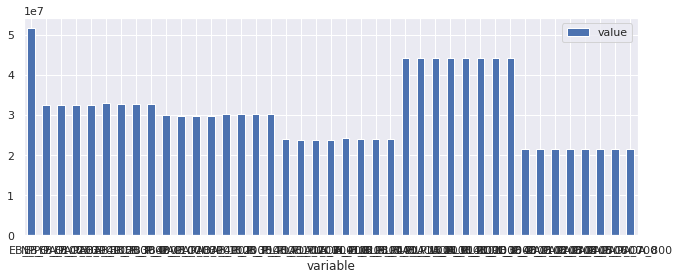

In [119]:
def rowToTex(row):
    clor = "black!30"
    if row["block_fill_10"] <= 1:
        clor ="green!50!black"
    elif row["block_fill_25"] <= 1:
        clor ="orange!50!black"
    elif row["block_fill_50"] <= 1:
        clor ="blue!50!black"
    elif row["block_fill_75"] <= 1:
        clor ="brown!50!black"
    elif row["block_fill"] <= 1:
        clor ="red!50!black"
    
    return "\draw [{}] ({},0)--++(0,{}) node[above, rotate=45, black, anchor=west, xshift=-.1cm] {{\scriptsize {}}};".format(clor, row['order'],
                                          row['value'] / 10**5,
                                          row["name"].replace("|", "$|$").replace("_","\_"))

sim = loadFile()
#display(sim)
#display(sim)
sim2 = transformMelted(pd.melt(sim, ['#']), "value") # "discounted_value"

sim_n1000 = sim2[sim2["#"] == 1000]
sim_n1000.plot.bar(x='variable', y='value', rot=0)


#display(sim_n1000)

sim_n1000["order"] = 1
sim_n1000["order"] = sim_n1000.order.cumsum()

sim_n1000["tex"] = sim_n1000.apply(rowToTex, axis=1)

sim_n1000["tex"].to_csv(dataPath / "bar_1000_coordinates.tex",
                        index=False,header=False, quoting=csv.QUOTE_NONE, quotechar="",  escapechar="", sep="\t")
sim_n1000["tex"]

Gas limits for graph drawing

In [88]:
print(BLOCKGASLIMIT_10 / 10 ** 5)
print(BLOCKGASLIMIT_25 / 10 ** 5)
print(BLOCKGASLIMIT_50 / 10 ** 5)
print(BLOCKGASLIMIT_75 / 10 ** 5)
print(BLOCKGASLIMIT / 10 ** 5)

7.99768
19.99418
39.98836
59.98254
79.97671


# Playgound

In [31]:
(118921288 * CHEAPEST_GAS_PRICE_WEI) / 10**18

0.06897434704

In [71]:
sim = loadFile()
#display(sim)
#display(sim)
sim2 = transformMelted(pd.melt(sim, ['#']), "value") # "discounted_value"

sim2[sim2["variable"] == "IB_PL_U_100"]

,#,variable,value,name,batch_size,discounted_value,cost_eth_low,cost_eth_median,cost_eth_high,#tx,...,#tx_needed_25,#tx_needed_50,#tx_needed_75,#tx_needed,gas_per_tx,block_fill_10,block_fill_25,block_fill_50,block_fill_75,block_fill
1450,100,IB_PL_U_100,4424280,INTERNAL_BATCH|PULL|USER_COST|100,100,2924280,0.002566,0.046455,1.039706,1.0,...,2.212784,0.737595,0.553196,0.553196,4.424280e+06,5.531954,2.212784,1.106392,0.737595,0.553196
1451,200,IB_PL_U_100,8848240,INTERNAL_BATCH|PULL|USER_COST|100,100,5848240,0.005132,0.092907,2.079336,2.0,...,4.425408,1.475136,1.106352,1.106352,4.424120e+06,5.531754,2.212704,1.106352,0.737568,0.553176
1452,300,IB_PL_U_100,13272008,INTERNAL_BATCH|PULL|USER_COST|100,100,8772008,0.007698,0.139356,3.118922,3.0,...,6.637936,2.212645,1.659484,1.659484,4.424003e+06,5.531607,2.212645,1.106323,0.737548,0.553161
1453,400,IB_PL_U_100,17696160,INTERNAL_BATCH|PULL|USER_COST|100,100,11696160,0.010264,0.185810,4.158598,4.0,...,8.850656,2.950219,2.212664,2.212664,4.424040e+06,5.531654,2.212664,1.106332,0.737555,0.553166
1454,500,IB_PL_U_100,22120312,INTERNAL_BATCH|PULL|USER_COST|100,100,14620312,0.012830,0.232263,5.198273,5.0,...,11.063375,3.687792,2.765844,2.765844,4.424062e+06,5.531682,2.212675,1.106338,0.737558,0.553169
1455,600,IB_PL_U_100,26543760,INTERNAL_BATCH|PULL|USER_COST|100,100,17543760,0.015395,0.278709,6.237784,6.0,...,13.275743,4.425248,3.318936,3.318936,4.423960e+06,5.531554,2.212624,1.106312,0.737541,0.553156
1456,700,IB_PL_U_100,30878952,INTERNAL_BATCH|PULL|USER_COST|100,100,20378952,0.017910,0.324229,7.256554,7.0,...,15.443970,5.147990,3.860993,3.860993,4.411279e+06,5.515698,2.206281,1.103141,0.735427,0.551570
1457,800,IB_PL_U_100,35393024,INTERNAL_BATCH|PULL|USER_COST|100,100,23393024,0.020528,0.371627,8.317361,8.0,...,17.701663,5.900554,4.425416,4.425416,4.424128e+06,5.531764,2.212708,1.106354,0.737569,0.553177
1458,900,IB_PL_U_100,39817048,INTERNAL_BATCH|PULL|USER_COST|100,100,26317048,0.023094,0.418079,9.357006,9.0,...,19.914319,6.638106,4.978580,4.978580,4.424116e+06,5.531750,2.212702,1.106351,0.737567,0.553176
1459,1000,IB_PL_U_100,44240880,INTERNAL_BATCH|PULL|USER_COST|100,100,29240880,0.025660,0.464529,10.396607,10.0,...,22.126879,7.375626,5.531720,5.531720,4.424088e+06,5.531714,2.212688,1.106344,0.737563,0.553172


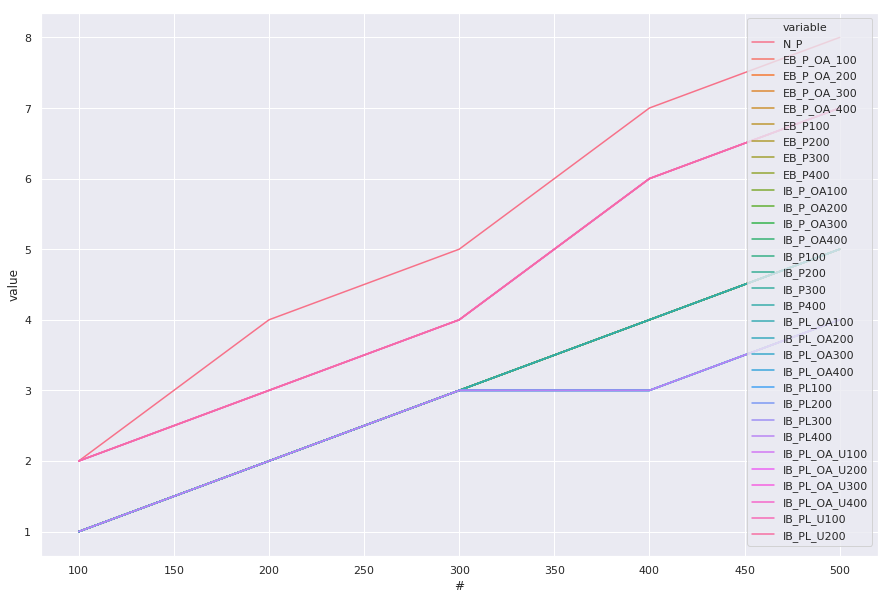

In [37]:
from matplotlib import pyplot
from math import ceil
sim = pd.read_csv(sim_file, sep=";")

sim2 = pd.melt(sim, ['#'])
sim2 = sim2.dropna()

sim2["discount"] = sim2["value"].apply(lambda x: ceil(float(x) / (BLOCKGASLIMIT * 0.5)))

#display(sim2)

fig, ax = pyplot.subplots(figsize=(15, 10))

sns.lineplot(ax = ax, x="#", y = "value", hue='variable', data=sim2)
##axes = sim.lineplot(marker='.', alpha=0.5, linestyle='dashed', figsize=(11, 9), subplots=False)

#ax.axhline(linewidth=1, y=6712392, color='r', linestyle="--")